# Twitter sentiment analysis

I'll study a dataset containing the various covid tweets from Kaggle at https://www.kaggle.com/gpreda/covid19-tweets

In [3]:
import pandas as pd

# Matplot for plots
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn, I'll need especially for the final plots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras for Deep Learning
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Natural language toolkit
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

add the log and download the stopwords from the natural language processing kit

In [4]:
# Set log
logging.basicConfig(format='%(message)s', level=logging.INFO)

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ricca\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

read the content of the file from the csv

In [11]:
# read the data from the file
filepath = 'covid19_tweets.csv'
data = pd.read_csv(filepath, sep=',')

data.head(10)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False
5,🎹 Franz Schubert,Новоро́ссия,🎼 #Новоро́ссия #Novorossiya #оставайсядома #S...,2018-03-19 16:29:52,1180,1071,1287,False,2020-07-25 12:27:06,#coronavirus #covid19 deaths continue to rise....,"['coronavirus', 'covid19']",Twitter Web App,False
6,hr bartender,"Gainesville, FL",Workplace tips and advice served up in a frien...,2008-08-12 18:19:49,79956,54810,3801,False,2020-07-25 12:27:03,How #COVID19 Will Change Work in General (and ...,"['COVID19', 'Recruiting']",Buffer,False
7,Derbyshire LPC,NaN,NaN,2012-02-03 18:08:10,608,355,95,False,2020-07-25 12:27:00,You now have to wear face coverings when out s...,NaN,TweetDeck,False
8,Prathamesh Bendre,NaN,"A poet, reiki practitioner and a student of law.",2015-04-25 08:15:41,25,29,18,False,2020-07-25 12:26:59,Praying for good health and recovery of @Chouh...,"['covid19', 'covidPositive']",Twitter for Android,False
9,Member of Christ 🇨🇳🇺🇸🇮🇳🇮🇩🇧🇷🇳🇬🇧🇩🇷🇺,👇🏻location at link below👇🏻,"Just as the body is one & has many members, & ...",2014-08-17 04:53:22,55201,34239,29802,False,2020-07-25 12:26:54,POPE AS GOD - Prophet Sadhu Sundar Selvaraj. W...,"['HurricaneHanna', 'COVID19']",Twitter for iPhone,False


In [12]:
data.dtypes

user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
is_retweet            bool
dtype: object

### Visual representation

Show plots for the various data we have

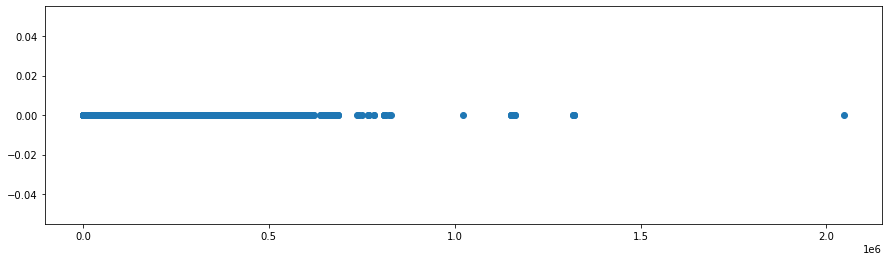

In [18]:
plt.figure(figsize=(15, 4))
plt.plot(data.user_favourites, data.is_retweet, ls='', marker='o')

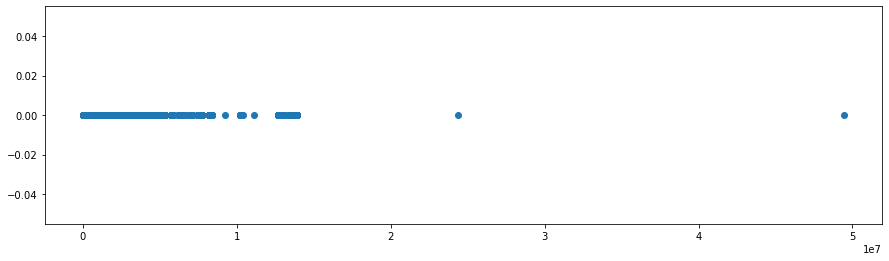

In [19]:
plt.figure(figsize=(15, 4))
plt.plot(data.user_followers, data.is_retweet, ls='', marker='o')

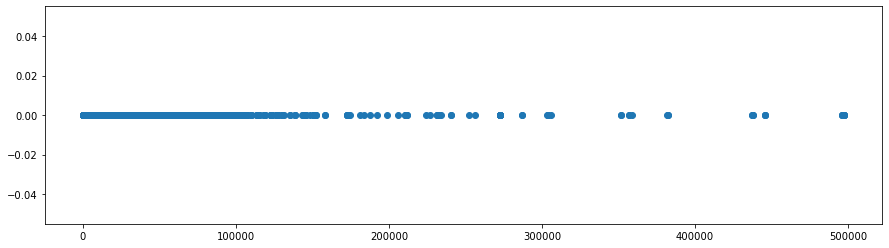

In [20]:
plt.figure(figsize=(15, 4))
plt.plot(data.user_friends, data.is_retweet, ls='', marker='o')

<AxesSubplot:>

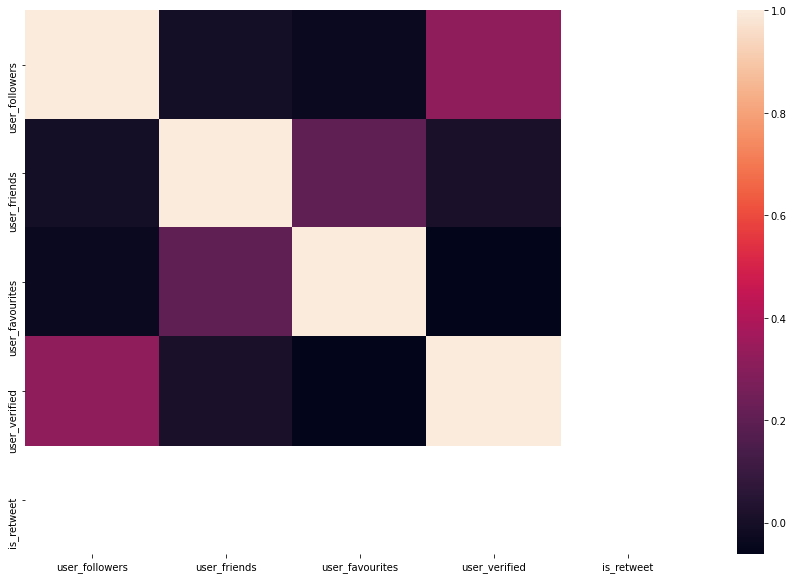

In [22]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(data.corr())

## Data cleaning and feature engineering

First of all it's important to check on the data and see if it's skewed or if there's something to be working on. Since I'll work on a DeepLearning model, the more features I have, the better I can work on, but I still need to ensure that the information is cleaned for the processing

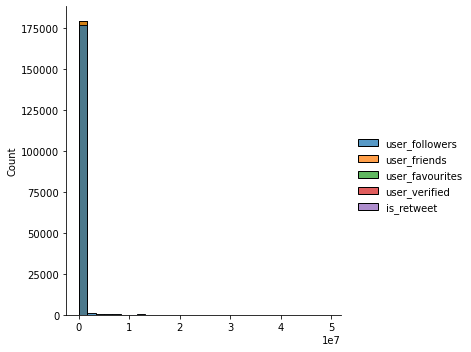

In [25]:
sns.displot(data, bins=30)

## Sentiment analysis

I can now start working on the sentiment analysis part

In [38]:
# Add column with data
data['target'] = np.random.choice([-1, 0, 1], data.shape[0])

In [39]:
dec_map = {-1: "Negative",0: "Neutral", 1: "Positive"}

# Simple function to decode the sentiment
def dec_sentiment(label):
    return dec_map[int(label)]

# We add the column target on the DataFrame
data.target = data.target.apply(lambda x: dec_sentiment(x))

Create the various information using English as language

- stop words
- stemmer

In [42]:
sw = stopwords.words("english")
stem = SnowballStemmer("english")

It's important now to clean the text for the tweets from information regarding users and links, and for that a regex will be used

In [43]:
def text_preprocess(text, stem=False):
    
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
    tokens = []
    
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [44]:
data.text = data.text.apply(lambda x: text_preprocess(x))

Split train and test

In [46]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)

print("train size:", len(X_train))
print("test size:", len(X_test))

train size: 125375
test size: 53733


### Working with word2vec

I'll now use word2vec to learn word associations from a large corpus of text

In [49]:
# some of the knowledge have been aquired with the w2v tutorial
# https://adventuresinmachinelearning.com/word2vec-keras-tutorial/
doc = [_text.split() for _text in X_train.text]

w2v = gensim.models.word2vec.Word2Vec(vector_size=200, window=7, min_count=7, workers=8)

2021-08-29 12:09:53,781 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=200, alpha=0.025)', 'datetime': '2021-08-29T12:09:53.781716', 'gensim': '4.0.1', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


In [50]:
w2v.build_vocab(doc)

2021-08-29 12:10:51,373 : INFO : collecting all words and their counts
2021-08-29 12:10:51,374 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-08-29 12:10:51,413 : INFO : PROGRESS: at sentence #10000, processed 108080 words, keeping 21776 word types
2021-08-29 12:10:51,462 : INFO : PROGRESS: at sentence #20000, processed 215671 words, keeping 33172 word types
2021-08-29 12:10:51,504 : INFO : PROGRESS: at sentence #30000, processed 323450 words, keeping 42259 word types
2021-08-29 12:10:51,546 : INFO : PROGRESS: at sentence #40000, processed 431410 words, keeping 50239 word types
2021-08-29 12:10:51,588 : INFO : PROGRESS: at sentence #50000, processed 539567 words, keeping 57242 word types
2021-08-29 12:10:51,639 : INFO : PROGRESS: at sentence #60000, processed 647170 words, keeping 63787 word types
2021-08-29 12:10:51,690 : INFO : PROGRESS: at sentence #70000, processed 755046 words, keeping 69654 word types
2021-08-29 12:10:51,733 : INFO : PROGRESS: at 

In [54]:
words = w2v.wv.index_to_key
vocabulary_size = len(words)

print("Vocabulary size", vocabulary_size)

Vocabulary size 15467


Train our model

In [57]:
w2v.wv.most_similar("covid")

[('covid19', 0.4595447778701782),
 ('coronavirus', 0.38082993030548096),
 ('364', 0.2836289703845978),
 ('842', 0.273364782333374),
 ('corona', 0.25135260820388794),
 ('versus', 0.24311982095241547),
 ('covid19sa', 0.239445760846138),
 ('new', 0.2327510267496109),
 ('associated', 0.2262677699327469),
 ('90', 0.22575807571411133)]

In [58]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.text)

vocabulary_size_new = len(tokenizer.word_index) + 1
print("Total words with the new vocubalary", vocabulary_size_new)

Total words with the new vocubalary 98007


In [59]:
X_train_new = pad_sequences(tokenizer.texts_to_sequences(X_train.text), maxlen=200)
X_test_new = pad_sequences(tokenizer.texts_to_sequences(X_test.text), maxlen=200)

In [60]:
enc = LabelEncoder()
enc.fit(X_train.target.tolist())

y_train = enc.transform(X_train.target.tolist())
y_test = enc.transform(X_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

Create the layer

In [73]:
layer_matrix = np.zeros((vocabulary_size_new, 200))

for word, i in tokenizer.word_index.items():
  if word in w2v.wv:
    layer_matrix[i] = w2v.wv[word]
    
print(layer_matrix.shape)

(98007, 200)


In [82]:
embedding_layer = Embedding(vocabulary_size_new, 200, weights=[layer_matrix], input_length=200, trainable=False)

In [83]:
embedding_layer

### Work on the model

Now that the information regarding the various data are complete; I'll use a Recurrent Neural Network, specifically the Long-Short Term Memory network with a simple sigmoid function

In [84]:
# Numpy requirement
# https://stackoverflow.com/questions/66207609/notimplementederror-cannot-convert-a-symbolic-tensor-lstm-2-strided-slice0-t
model = Sequential()
model.add(embedding_layer) # note that it requires numpy 1.19
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported